In [116]:
import pandas as pd
import os
import re
import numpy as np
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RepeatedKFold

from sklearn.metrics import f1_score, recall_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
sns.set_style('whitegrid')

path = r'C:\Users\chiar\Documents\Università\Text analytics\Data'
#path = r'D:\tirocinioLC\tirocinioLC'

Load pre-processed corpus

In [114]:
df = pd.read_json(path+'\df_final.json')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37693 entries, 1 to 54718
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   ID       37693 non-null  int64              
 1   Title    37690 non-null  object             
 2   Rating   37693 non-null  object             
 3   Author   37693 non-null  object             
 4   Date     37693 non-null  datetime64[ns, UTC]
 5   Chapter  37693 non-null  int64              
 6   Text     37693 non-null  object             
 7   N_Rev    37693 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 2.6+ MB
None


,ID,Title,Rating,Author,Date,Chapter,Text,N_Rev
1,2909917,Rilassati! Hai tutta la morte davanti!,verde,Tonks98,2014-11-15 00:00:00+00:00,1,"""Zi zieda, prego. Allora, quale ezzere zuo ""B...",3
4,1390250,Episodi della Old Generation 1.,verde,mrsreg,2012-11-17 00:00:00+00:00,1,Introduzione. Personaggi: Argus Gazza:...,0
5,1143283,In Noctem,verde,LilacLilium,2012-04-07 00:00:00+00:00,1,Questo mio piccolo lavoretto è ispirato a una ...,2
7,917615,Dirty flower.,verde,Rue,2012-07-01 00:00:00+00:00,1,"DIRTY FLOWER. Lo hai sempre saputo, Lily. ...",3
8,917635,Hawthorn and Unicorn Air,giallo,Tonna,2012-08-01 00:00:00+00:00,1,Before you read: Bentro...,4


<AxesSubplot:>

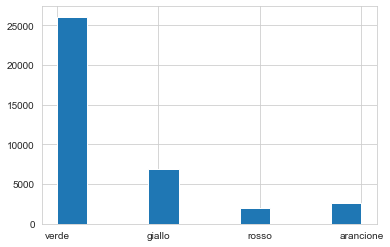

In [41]:
df.Rating.hist()

In [42]:
df.Rating.value_counts()

verde        26104
giallo        6927
arancione     2623
rosso         2039
Name: Rating, dtype: int64

In [43]:
bdf = df[(df['Rating']!='giallo') & (df['Rating']!='arancione')]

In [44]:
target = df[['Rating']]
del df['Rating']

In [45]:
#split on train-test 
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.30, random_state=42, stratify=target, shuffle=True) 

In [46]:
print(f"Train set size: {len(x_train)}\nTest set size: {len(x_test)}")

Train set size: 26385
Test set size: 11308


# Preprocessing

## Feature extraction with nltk and spacy

In [17]:
#!python -m spacy download it_core_news_sm

In [18]:
import nltk
import spacy
import re
nlp = spacy.load('it_core_news_sm')

doc_counter = 0
def reset_counter():
  global doc_counter
  doc_counter = 0

def increase_counter():
  global doc_counter
  doc_counter += 1
  if doc_counter % 100 == 0:
    print(doc_counter)

def spacy_nlp_tokenizer(text):
    increase_counter()

    # substituting all space characters with a single space
    text = re.sub('\s+', ' ', text)

    # we use spacy for main nlp tasks
    doc = nlp(text)
    # lemmatized tokens, skipping stopwords
    lemmas = ['LEMMA_'+token.lemma_ for token in doc if not token.is_stop]
    # entity_types
    entity_types = ['NER_'+token.ent_type_ for token in doc if token.ent_type_]

    # in case an entity linker is available, we can use it do put actual entities as
    # features, e.g. Queen Elizabeth, Elizabeth II, Her Majesty -> KB2912
    # see https://spacy.io/usage/training#entity-linker
    # entities = ['ENT_'+token.ent_kb_id_ for token in doc if token.ent_kb_id_]

    # we use a simple nltk function to create ngrams
    lemma_bigrams = ['BI_'+p1+'_'+p2 for p1,p2 in nltk.ngrams(lemmas,2)]
    lemma_trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(lemmas,3)]

    all_tokens = list()
    all_tokens.extend(lemmas)
    all_tokens.extend(lemma_bigrams)
    all_tokens.extend(lemma_trigrams)
    all_tokens.extend(entity_types)
    return all_tokens

In [61]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

### Tokenization 

In [20]:
#vect = CountVectorizer(analyzer=spacy_nlp_tokenizer, min_df=5)  
#reset_counter()
#X_train_tok = vect.fit_transform(x_train.Racconto_Text_Only)
#reset_counter()
#X_test_tok = vect.transform(x_test.Racconto_Text_Only)

In [21]:
#with open(path+r'\Rating\multiclass\x_train_tok.pkl','wb') as outfile:
#    pickle.dump(X_train_tok, outfile)
#with open(path+r'\Rating\multiclass\x_test_tok.pkl','wb') as outfile:
#    pickle.dump(X_test_tok, outfile)
#with open(path+r'\Rating\multiclass\vect.pkl','wb') as outfile:
#    pickle.dump(vect, outfile)

In [22]:
train_file = open(path+r"\Rating\multiclass\x_train_tok.pkl", "rb")
X_train_tok = pickle.load(train_file)

test_file = open(path+r"\Rating\multiclass\x_test_tok.pkl", "rb")
X_test_tok = pickle.load(test_file)

vect_file = open(path+r"\Rating\multiclass\vect.pkl", "rb")
vect = pickle.load(vect_file)

In [24]:
print(f"Lunghezza del vocabolario: {len(vect.vocabulary_)}")

Lunghezza del vocabolario: 914227


In [21]:
#vect.vocabulary_

# Rating Classification

In [25]:
pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k='all')),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

reset_counter()
pipeline.fit(X_train_tok, y_train.values.ravel())

reset_counter()
predictions = pipeline.predict(X_test_tok)

In [27]:
print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

   arancione       0.50      0.03      0.06       787
      giallo       0.43      0.14      0.21      2078
       rosso       0.77      0.64      0.70       612
       verde       0.76      0.98      0.86      7831

    accuracy                           0.74     11308
   macro avg       0.61      0.45      0.46     11308
weighted avg       0.68      0.74      0.67     11308

Confusion matrix:
[[  26  171   81  509]
 [  12  285   24 1757]
 [   8   61  389  154]
 [   6  150   12 7663]]


### Optimization

In [26]:
search_space = [{'sel__k': [10000, 100000, 250000, 500000, 'all'],
                 'learner':[MultinomialNB()],
                 'learner__alpha': [1e-3, 1e-2, 0.1, 1.0, 10.0],
                 'learner__fit_prior':[True, False]}, 
                {'sel__k': [10000, 100000, 250000, 500000, 'all'],
                 'learner':[LinearSVC()],
                 'learner__C': [0.01, 0.1, 1, 10, 100]},
                {'sel__k': [10000, 100000, 250000, 500000, 'all'], 
                 'learner':[LogisticRegression()],
                 'learner__solver':["liblinear"],
                 'learner__penalty' : ['l1', 'l2'],
                 'learner__C': [0.01, 0.1, 1, 10, 100]} 
               ]

opt_pipeline = Pipeline([
#    ('vect', CountVectorizer()),  # feature extraction
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

In [28]:
opt_search = GridSearchCV(opt_pipeline, 
                                      search_space,
                                      cv=3, n_jobs = 4, verbose=True).fit(X_train_tok, y_train.values.ravel())

Fitting 3 folds for each of 125 candidates, totalling 375 fits


C:\Users\chiar\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [29]:
opt_search.best_params_

{'learner': LogisticRegression(C=100, solver='liblinear'),
 'learner__C': 100,
 'learner__penalty': 'l2',
 'learner__solver': 'liblinear',
 'sel__k': 'all'}

In [30]:
opt_search.cv_results_

{'mean_fit_time': array([   3.62208446,    4.5288926 ,    5.13820759,    7.32212281,
           9.63475633,    3.51315991,    4.14589715,    5.09021211,
           7.236329  ,    9.88184897,    3.55349048,    3.87724368,
           4.86170475,    7.42594592,    9.38192312,    3.27139584,
           3.90982978,    5.52135396,    7.77439483,   11.54193298,
           3.54549615,    4.16753523,    5.50020806,    7.78270006,
          10.56871255,    3.77418478,    4.24977859,    4.69897715,
           7.3731451 ,   10.05078236,    3.4598647 ,    4.17657423,
           5.11354359,    6.97605443,   10.35176341,    3.48587894,
           3.981668  ,    4.88995043,    7.73618698,   10.58065017,
           4.00749516,    4.72816777,    4.26327173,    5.98708582,
           8.5526437 ,    2.81130918,    3.34975123,    4.14591249,
           6.55081177,    8.50759292,    4.0377655 ,    5.25734639,
           6.81623212,   13.07578214,   20.67974758,    5.90473056,
           6.11120391,    8.444

In [31]:
opt_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x0000025C6868DD30>)),
                ('tfidf', TfidfTransformer()),
                ('learner', LogisticRegression(C=100, solver='liblinear'))])

In [32]:
opt_predictions = opt_search.best_estimator_.predict(X_test_tok)

In [33]:
print('Classification report:')
print(classification_report(y_test, opt_predictions))
print('Confusion matrix:')
opt_cm = confusion_matrix(y_test, opt_predictions)
print(opt_cm)

Classification report:
              precision    recall  f1-score   support

   arancione       0.35      0.05      0.09       787
      giallo       0.41      0.17      0.24      2078
       rosso       0.79      0.63      0.70       612
       verde       0.77      0.96      0.85      7831

    accuracy                           0.74     11308
   macro avg       0.58      0.45      0.47     11308
weighted avg       0.67      0.74      0.68     11308

Confusion matrix:
[[  40  194   78  475]
 [  36  354   18 1670]
 [  21   65  388  138]
 [  17  253    9 7552]]


RandomSearchCV on restrict parameter range

In [34]:
rand_search_space = [{'learner__C': np.arange(50, 100, 10)}]

opt_pipeline = Pipeline([
#    ('vect', CountVectorizer()),  # feature extraction
    ('sel', SelectKBest(chi2, k='all')),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LogisticRegression(solver = 'liblinear', penalty = 'l2'))  # learning algorithm
])

In [36]:
from sklearn.model_selection import RandomizedSearchCV
opt_rsearch = RandomizedSearchCV(opt_pipeline, 
                                rand_search_space,
                                cv=3, n_jobs = 4, verbose=True).fit(X_train_tok, y_train.values.ravel())

C:\Users\chiar\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\Users\chiar\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [37]:
opt_rsearch.best_params_

{'learner__C': 90}

In [38]:
opt_rsearch.cv_results_

{'mean_fit_time': array([401.19844874, 417.94750245, 418.57340789, 408.83339747,
        255.76138902]),
 'std_fit_time': array([ 2.81196708, 10.51268024,  7.54339896,  2.74024478,  4.20751885]),
 'mean_score_time': array([3.84658225, 4.75797327, 3.8578709 , 4.18003241, 2.39357313]),
 'std_score_time': array([0.76216091, 1.22149192, 0.42520472, 0.26125259, 0.84954168]),
 'param_learner__C': masked_array(data=[50, 60, 70, 80, 90],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learner__C': 50},
  {'learner__C': 60},
  {'learner__C': 70},
  {'learner__C': 80},
  {'learner__C': 90}],
 'split0_test_score': array([0.73291643, 0.73291643, 0.73268903, 0.73291643, 0.73348493]),
 'split1_test_score': array([0.73473565, 0.73530415, 0.73530415, 0.73564525, 0.73598636]),
 'split2_test_score': array([0.73382604, 0.73393974, 0.73473565, 0.73462194, 0.73473565]),
 'mean_test_score': array([0.73382604, 0.73405344, 0.73424294, 0

In [39]:
opt_rsearch.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x0000025C6868DD30>)),
                ('tfidf', TfidfTransformer()),
                ('learner', LogisticRegression(C=90, solver='liblinear'))])

In [40]:
opt_predictions = opt_rsearch.best_estimator_.predict(X_test_tok)

In [41]:
print('Classification report:')
print(classification_report(y_test, opt_predictions))
print('Confusion matrix:')
opt_cm = confusion_matrix(y_test, opt_predictions)
print(opt_cm)

Classification report:
              precision    recall  f1-score   support

   arancione       0.36      0.05      0.09       787
      giallo       0.41      0.17      0.24      2078
       rosso       0.79      0.63      0.70       612
       verde       0.77      0.96      0.86      7831

    accuracy                           0.74     11308
   macro avg       0.58      0.45      0.47     11308
weighted avg       0.67      0.74      0.68     11308

Confusion matrix:
[[  40  194   78  475]
 [  34  355   17 1672]
 [  20   67  386  139]
 [  17  250    9 7555]]


# Classification verde vs rosso

<AxesSubplot:>

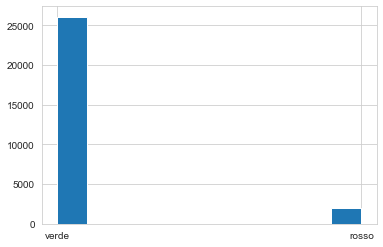

In [47]:
bdf.Rating.hist()

In [48]:
bdf.Rating.value_counts()

verde    26104
rosso     2039
Name: Rating, dtype: int64

In [49]:
btarget = bdf[['Rating']]
del bdf['Rating']

In [51]:
#split on train-test 
x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(bdf, btarget, test_size=0.30, random_state=42, stratify=btarget, shuffle=True) 

In [52]:
print(f"Train set size: {len(x_train_bin)}\nTest set size: {len(x_test_bin)}")

Train set size: 19700
Test set size: 8443


In [28]:
#vect = CountVectorizer(analyzer=spacy_nlp_tokenizer, min_df=5)  
#reset_counter()
#X_train_tok = vect.fit_transform(x_train.Racconto_Text_Only)
#reset_counter()
#X_test_tok = vect.transform(x_test.Racconto_Text_Only)

In [ ]:
#with open(path+r'\Rating\x_train_tok_verdirossi.pkl','wb') as outfile:
#    pickle.dump(X_train_tok,outfile)
#with open(path+r'\Rating\x_test_tok_verdirossi.pkl','wb') as outfile:
#    pickle.dump(X_test_tok,outfile)
#with open(path+r'\Rating\vect_verdirossi.pkl','wb') as outfile:
#    pickle.dump(vect,outfile)

In [53]:
btrain_file = open(path+r"\Rating\x_train_tok_verdirossi.pkl", "rb")
x_train_bin_tok = pickle.load(btrain_file)

btest_file = open(path+r"\Rating\x_test_tok_verdirossi.pkl", "rb")
x_test_bin_tok = pickle.load(btest_file)

bvect_file = open(path+r"\Rating\vect_verdirossi.pkl", "rb")
bvect = pickle.load(bvect_file)

In [54]:
print(f"Lunghezza del vocabolario: {len(bvect.vocabulary_)}")

Lunghezza del vocabolario: 629377


In [56]:
reset_counter()
pipeline.fit(x_train_bin_tok, y_train_bin.values.ravel())

reset_counter()
ratingb_predictions = pipeline.predict(x_test_bin_tok)

In [57]:
print('Classification report:')
print(classification_report(y_test_bin, ratingb_predictions))
print('Confusion matrix:')
ratingb_cm = confusion_matrix(y_test_bin, ratingb_predictions)
print(ratingb_cm)

Classification report:
              precision    recall  f1-score   support

       rosso       0.97      0.65      0.78       612
       verde       0.97      1.00      0.99      7831

    accuracy                           0.97      8443
   macro avg       0.97      0.82      0.88      8443
weighted avg       0.97      0.97      0.97      8443

Confusion matrix:
[[ 396  216]
 [  12 7819]]


## Optimization 

In [59]:
bsearch_space = [{'sel__k': [10000, 100000, 250000, 'all'],
                 'learner':[MultinomialNB(class_prior = [.2, .1])],
                 'learner__alpha': [1e-3, 1e-2, 0.1, 1.0, 10.0],
                 'learner__fit_prior':[True, False]}, 
                {'sel__k': [10000, 100000, 250000, 'all'],
                 'learner':[LinearSVC(class_weight = {'rosso':2, 'verde': 1})],
                 'learner__C': [0.01, 0.1, 1, 10, 100]},
                {'sel__k': [10000, 100000, 250000, 'all'], 
                 'learner':[LogisticRegression(class_weight = {'rosso':2, 'verde': 1})],
                 'learner__solver':["liblinear"],
                 'learner__penalty' : ['l1', 'l2'],
                 'learner__C': [0.01, 0.1, 1, 10, 100]} 
               ]

brating_opt_pipeline = Pipeline([
#    ('vect', CountVectorizer()),  # feature extraction
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC(class_weight={'rosso':2,'verde':1}))  # learning algorithm
])

scoring = make_scorer(f1_score, greater_is_better=True, pos_label='rosso')

In [63]:
brating_opt_search = GridSearchCV(brating_opt_pipeline, 
                                 bsearch_space,
                                 scoring = scoring,
                                 cv=3, n_jobs = 4, verbose=True).fit(x_train_bin_tok, y_train_bin.values.ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [64]:
brating_opt_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x000001B152FECDC0>)),
                ('tfidf', TfidfTransformer()),
                ('learner',
                 LogisticRegression(C=100,
                                    class_weight={'rosso': 2, 'verde': 1},
                                    penalty='l1', solver='liblinear'))])

In [65]:
brating_opt_predictions = brating_opt_search.best_estimator_.predict(x_test_bin_tok)

In [66]:
print('Classification report:')
print(classification_report(y_test_bin, brating_opt_predictions))
print('Confusion matrix:')
brating_opt_cm = confusion_matrix(y_test_bin, brating_opt_predictions)
print(brating_opt_cm)

Classification report:
              precision    recall  f1-score   support

       rosso       0.87      0.75      0.81       612
       verde       0.98      0.99      0.99      7831

    accuracy                           0.97      8443
   macro avg       0.92      0.87      0.90      8443
weighted avg       0.97      0.97      0.97      8443

Confusion matrix:
[[ 459  153]
 [  69 7762]]


In [92]:
model_opt_pipeline = Pipeline([
    ('sel', SelectKBest(k='all', score_func=chi2)),
    ('tfidf', TfidfTransformer()),
    ('learner', LogisticRegression(C=10,
                                    class_weight={'rosso': 2, 'verde': 1},
                                    penalty='l1', solver='liblinear'))
                                      ])

In [93]:
model_opt_pipeline.fit(x_train_bin_tok, y_train_bin.values.ravel())

Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x000001B152FECDC0>)),
                ('tfidf', TfidfTransformer()),
                ('learner',
                 LogisticRegression(C=10, class_weight={'rosso': 2, 'verde': 1},
                                    penalty='l1', solver='liblinear'))])

### Inspecting the pipeline

In [94]:
rating_tokenizer = bvect
rating_selector = model_opt_pipeline.named_steps['sel']
rating_classifier = model_opt_pipeline.named_steps['learner']

In [96]:
rating_feature_names = rating_tokenizer.get_feature_names()
rating_feats_w_score = list()
for index,(selected,score) in enumerate(zip(rating_selector.get_support(),rating_selector.scores_)):
    rating_feats_w_score.append((score,selected,rating_feature_names[index]))
rating_feats_w_score = sorted(rating_feats_w_score)
len(rating_feats_w_score)

629377

In [97]:
rating_feats_w_classifier_weight = list()
for index,weight in enumerate(rating_selector.inverse_transform(rating_classifier.coef_)[0]):
    if weight!=0:
        rating_feats_w_classifier_weight.append((weight,rating_feature_names[index]))
rating_feats_w_classifier_weight = sorted(rating_feats_w_classifier_weight)
len(rating_feats_w_classifier_weight)

1133

In [98]:
rating_feats_w_classifier_weight[-100:]

[(6.599432760260515, 'BI_LEMMA_Harry_LEMMA_guardare'),
 (6.675969780552663, 'BI_LEMMA_»_LEMMA_.'),
 (6.759003311775778, 'LEMMA_comprare'),
 (6.893761624527026, 'BI_LEMMA_,_LEMMA_il'),
 (6.966431248992194, 'LEMMA_frase'),
 (7.002032500463452, 'BI_LEMMA_._LEMMA_-Ma'),
 (7.024506696855564, 'LEMMA_correre'),
 (7.033818242725572, 'LEMMA_braccio'),
 (7.110717564896361, 'LEMMA_credere'),
 (7.138652916555201, 'LEMMA_dalla'),
 (7.147248266442415, 'LEMMA_piccolo'),
 (7.200377332990953, 'LEMMA_moglie'),
 (7.314298430160042, 'BI_LEMMA_Draco_LEMMA_Malfoy'),
 (7.332133808529103, 'LEMMA_profumare'),
 (7.338974041739393, 'BI_LEMMA_Potter_LEMMA_e'),
 (7.344273993775025, 'BI_LEMMA_._LEMMA_girare'),
 (7.47154516037599, 'LEMMA_terra'),
 (7.478380779626793, 'LEMMA_sedia'),
 (7.505906300702909, 'LEMMA_circondare'),
 (7.666709077259793, 'LEMMA_diverso'),
 (7.667826179540596, 'LEMMA_Natale'),
 (7.689570392529787, 'LEMMA_scrivere'),
 (7.750202927518971, 'LEMMA_raccontare'),
 (7.807724856867375, 'BI_LEMMA_sposa

In [99]:
rating_feats_w_classifier_weight[:100]

[(-135.09236162285455, 'LEMMA_erezione'),
 (-105.16557192033974, 'LEMMA_orgasmo'),
 (-83.23114641983798, 'LEMMA_capezzolo'),
 (-83.2063692523003, 'LEMMA_Prologo'),
 (-75.01655053676055, 'LEMMA_CAPITOLO'),
 (-62.363372882716085, 'LEMMA_seno'),
 (-59.73900411995162, 'LEMMA_gemito'),
 (-58.641602320835915, 'LEMMA_spinto'),
 (-55.85402200041977, 'LEMMA_gemere'),
 (-48.29723116107557, 'BI_LEMMA_gamba_LEMMA_,'),
 (-45.83517869735735, 'LEMMA_copertura'),
 (-43.6657383982502, 'BI_LEMMA_e_LEMMA_famoso'),
 (-43.44585072368025, 'LEMMA_ansimare'),
 (-43.350431126616016, 'LEMMA_pantalone'),
 (-42.3423531484445, 'LEMMA_Capitolo'),
 (-40.895323471138006, 'LEMMA_coscia'),
 (-40.70734154019333, 'LEMMA_capitolare'),
 (-39.31468833514485, 'LEMMA_smistamento'),
 (-37.41900372766273, 'LEMMA_spogliare'),
 (-36.61677448392007, 'LEMMA_sesso'),
 (-36.2878458370765, 'LEMMA_-Lei'),
 (-35.98702539992929, 'BI_LEMMA_:_LEMMA_1/1'),
 (-34.79834839994038, 'LEMMA_eccitazione'),
 (-34.419722707489505, 'BI_LEMMA_scena_LE